Import important parameter

In [1]:
inputsize = 23**2
e = 0.05

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 16.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 16*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <1000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
error=10e-11
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

sqrtinputsize = int(np.sqrt(inputsize))
sqrtmidputsize = int(sqrtinputsize/2)
midputsize = int(sqrtmidputsize**2)
sqrtoutputsize = int(sqrtmidputsize/2)
outputsize = int(sqrtoutputsize**2)

h = 1/(sqrtinputsize-1)
H = 1/(sqrtoutputsize-1)
A0 = Poisson(inputsize)
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A1 = gallery.nonlinearPoisson((n,n), kx, ky)
n = inputsize
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
Media = a(X,Y)
R1 = Restriction(inputsize)
R2 = Restriction(midputsize)
R  = np.matmul(R2, R1)
P = 16*np.transpose(R)

GMM on fine grid

In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, w, error)

Residual = 14.281908610905381
Interation = 1
Residual = 5.0198328293942085
Interation = 2
Residual = 3.3897205551172074
Interation = 3
Residual = 2.4650549765584224
Interation = 4
Residual = 1.8257002001369447
Interation = 5
Residual = 1.363813773967379
Interation = 6
Residual = 1.0247566392887315
Interation = 7
Residual = 0.7735219555147046
Interation = 8
Residual = 0.5861301922872718
Interation = 9
Residual = 0.4456483492007843
Interation = 10
Residual = 0.33989551184534883
Interation = 11
Residual = 0.260000385903303
Interation = 12
Residual = 0.19944588222720477
Interation = 13
Residual = 0.15341345165420625
Interation = 14
Residual = 0.11832222222196659
Interation = 15
Residual = 0.09149978381119914
Interation = 16
Residual = 0.07094435720278777
Interation = 17
Residual = 0.055151561555907946
Interation = 18
Residual = 0.04298742546677086
Interation = 19
Residual = 0.03359480812945585
Interation = 20
Residual = 0.026324131049492026
Interation = 21
Residual = 0.020681902216455973
I

Error GMM on fine grid

In [6]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
GMMU = GMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = GMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
2.4417015967072357
L2 norm: 
0.15710168447282757
H1 norm: 
1.8115348766172061
Energy norm: 
0.19396479440230935
L2 norm: 
0.31420336894565515
H1 norm: 
0.20299757818658024


Solution

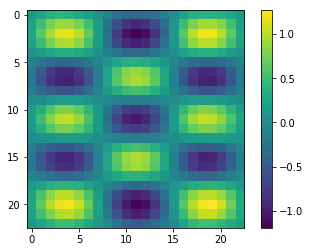

In [7]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

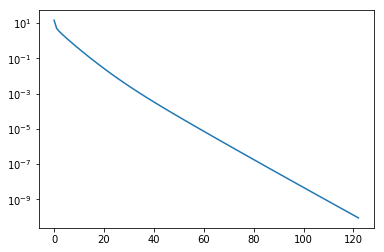

In [8]:
plt.semilogy(GMM_Res)

Radius

In [9]:
GMM_Radius = rho(inputsize,A1.to_full(),16*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.8478999766255483


Global DMM optimization

In [10]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, 
                                                           learning_rate = 1e-6,accept_radius =
                                                           GMM_Radius*10,step_length =  1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.8242898914865775
L = 0.03
rho = 0.8243253020365127
L = 0.04
rho = 0.8243847278233327
L = 0.05
rho = 0.8244666040310006
L = 0.060000000000000005
rho = 0.8245694055797526
L = 0.07
rho = 0.8246916538742127
L = 0.08
rho = 0.8248319223745942
L = 0.09
rho = 0.8249888410140555
L = 0.09999999999999999
rho = 0.8251610995165822
L = 0.10999999999999999
rho = 0.8253474496930671
L = 0.11999999999999998
rho = 0.8255467068091573
L = 0.12999999999999998
rho = 0.8257577501278277
L = 0.13999999999999999
rho = 0.8259795227335273
L = 0.15
rho = 0.826211030744216
L = 0.16
rho = 0.826451342013691
L = 0.17
rho = 0.826699584420227
L = 0.18000000000000002
rho = 0.8269549438295688
L = 0.19000000000000003
rho = 0.8272166618113801
L = 0.20000000000000004
rho = 0.8274840331789413
L = 0.21000000000000005
rho = 0.827756403412619
L = 0.22000000000000006
rho = 0.8280331660187139
L = 0.23000000000000007
rho = 0.8283137598669414
L = 0.24000000000000007
rho = 0.8285976665421649
L = 

the 27 steps
rho = 0.8478862370892846
the 28 steps
rho = 0.8478861135416845
the 29 steps
rho = 0.847885989996821
the 30 steps
rho = 0.8478858664546934
the 31 steps
rho = 0.847885742915302
the 32 steps
rho = 0.8478856193786461
the 33 steps
rho = 0.8478854958447256
the 34 steps
rho = 0.8478853723135402
the 35 steps
rho = 0.8478852487850893
the 36 steps
rho = 0.8478851252593729
the 37 steps
rho = 0.8478850017363907
the 38 steps
rho = 0.8478848782161422
the 39 steps
rho = 0.8478847546986271
the 40 steps
rho = 0.8478846311838454
the 41 steps
rho = 0.8478845076717966
the 42 steps
rho = 0.8478843841624804
the 43 steps
rho = 0.8478842606558964
the 44 steps
rho = 0.8478841371520445
the 45 steps
rho = 0.8478840136509243
the 46 steps
rho = 0.8478838901525354
the 47 steps
rho = 0.8478837666568777
the 48 steps
rho = 0.8478836431639508
the 49 steps
rho = 0.8478835196737544
the 50 steps
rho = 0.8478833961862882
the 51 steps
rho = 0.847883272701552
the 52 steps
rho = 0.8478831492195452
the 53 steps
rh

the 168 steps
rho = 0.8478688437501551
the 169 steps
rho = 0.8478687205854537
the 170 steps
rho = 0.8478685974234468
the 171 steps
rho = 0.847868474264134
the 172 steps
rho = 0.8478683511075154
the 173 steps
rho = 0.8478682279535902
the 174 steps
rho = 0.8478681048023584
the 175 steps
rho = 0.8478679816538197
the 176 steps
rho = 0.8478678585079737
the 177 steps
rho = 0.8478677353648202
the 178 steps
rho = 0.8478676122243588
the 179 steps
rho = 0.8478674890865894
the 180 steps
rho = 0.8478673659515116
the 181 steps
rho = 0.847867242819125
the 182 steps
rho = 0.8478671196894293
the 183 steps
rho = 0.8478669965624244
the 184 steps
rho = 0.8478668734381098
the 185 steps
rho = 0.8478667503164854
the 186 steps
rho = 0.8478666271975508
the 187 steps
rho = 0.8478665040813057
the 188 steps
rho = 0.8478663809677498
the 189 steps
rho = 0.8478662578568829
the 190 steps
rho = 0.8478661347487045
the 191 steps
rho = 0.8478660116432146
the 192 steps
rho = 0.8478658885404127
the 193 steps
rho = 0.84786

the 308 steps
rho = 0.8478516267784424
the 309 steps
rho = 0.8478515039881268
the 310 steps
rho = 0.8478513812004649
the 311 steps
rho = 0.8478512584154564
the 312 steps
rho = 0.847851135633101
the 313 steps
rho = 0.8478510128533983
the 314 steps
rho = 0.8478508900763483
the 315 steps
rho = 0.8478507673019505
the 316 steps
rho = 0.8478506445302046
the 317 steps
rho = 0.8478505217611105
the 318 steps
rho = 0.8478503989946677
the 319 steps
rho = 0.8478502762308763
the 320 steps
rho = 0.8478501534697354
the 321 steps
rho = 0.8478500307112451
the 322 steps
rho = 0.847849907955405
the 323 steps
rho = 0.847849785202215
the 324 steps
rho = 0.8478496624516745
the 325 steps
rho = 0.8478495397037835
the 326 steps
rho = 0.8478494169585415
the 327 steps
rho = 0.8478492942159483
the 328 steps
rho = 0.8478491714760037
the 329 steps
rho = 0.8478490487387073
the 330 steps
rho = 0.8478489260040588
the 331 steps
rho = 0.8478488032720579
the 332 steps
rho = 0.8478486805427045
the 333 steps
rho = 0.847848

the 448 steps
rho = 0.8478344618262891
the 449 steps
rho = 0.8478343394047037
the 450 steps
rho = 0.847834216985732
the 451 steps
rho = 0.8478340945693739
the 452 steps
rho = 0.8478339721556288
the 453 steps
rho = 0.8478338497444967
the 454 steps
rho = 0.8478337273359772
the 455 steps
rho = 0.84783360493007
the 456 steps
rho = 0.8478334825267747
the 457 steps
rho = 0.8478333601260915
the 458 steps
rho = 0.8478332377280194
the 459 steps
rho = 0.8478331153325587
the 460 steps
rho = 0.8478329929397088
the 461 steps
rho = 0.8478328705494697
the 462 steps
rho = 0.8478327481618406
the 463 steps
rho = 0.8478326257768218
the 464 steps
rho = 0.8478325033944129
the 465 steps
rho = 0.8478323810146133
the 466 steps
rho = 0.847832258637423
the 467 steps
rho = 0.8478321362628415
the 468 steps
rho = 0.8478320138908688
the 469 steps
rho = 0.8478318915215044
the 470 steps
rho = 0.8478317691547482
the 471 steps
rho = 0.8478316467905996
the 472 steps
rho = 0.8478315244290587
the 473 steps
rho = 0.8478314

the 588 steps
rho = 0.8478173481101597
the 589 steps
rho = 0.8478172260517671
the 590 steps
rho = 0.8478171039959491
the 591 steps
rho = 0.8478169819427054
the 592 steps
rho = 0.8478168598920358
the 593 steps
rho = 0.84781673784394
the 594 steps
rho = 0.8478166157984176
the 595 steps
rho = 0.8478164937554684
the 596 steps
rho = 0.8478163717150922
the 597 steps
rho = 0.8478162496772886
the 598 steps
rho = 0.8478161276420575
the 599 steps
rho = 0.8478160056093984
the 600 steps
rho = 0.8478158835793111
the 601 steps
rho = 0.8478157615517954
the 602 steps
rho = 0.847815639526851
the 603 steps
rho = 0.8478155175044776
the 604 steps
rho = 0.847815395484675
the 605 steps
rho = 0.8478152734674428
the 606 steps
rho = 0.8478151514527807
the 607 steps
rho = 0.8478150294406885
the 608 steps
rho = 0.847814907431166
the 609 steps
rho = 0.8478147854242127
the 610 steps
rho = 0.8478146634198287
the 611 steps
rho = 0.8478145414180134
the 612 steps
rho = 0.8478144194187666
the 613 steps
rho = 0.84781429

the 728 steps
rho = 0.8478002848628403
the 729 steps
rho = 0.8478001631622182
the 730 steps
rho = 0.8478000414641322
the 731 steps
rho = 0.8477999197685824
the 732 steps
rho = 0.8477997980755683
the 733 steps
rho = 0.8477996763850896
the 734 steps
rho = 0.8477995546971461
the 735 steps
rho = 0.8477994330117375
the 736 steps
rho = 0.8477993113288635
the 737 steps
rho = 0.8477991896485241
the 738 steps
rho = 0.8477990679707187
the 739 steps
rho = 0.847798946295447
the 740 steps
rho = 0.847798824622709
the 741 steps
rho = 0.8477987029525043
the 742 steps
rho = 0.8477985812848324
the 743 steps
rho = 0.8477984596196935
the 744 steps
rho = 0.847798337957087
the 745 steps
rho = 0.8477982162970128
the 746 steps
rho = 0.8477980946394705
the 747 steps
rho = 0.8477979729844598
the 748 steps
rho = 0.8477978513319806
the 749 steps
rho = 0.8477977296820325
the 750 steps
rho = 0.8477976080346152
the 751 steps
rho = 0.8477974863897285
the 752 steps
rho = 0.8477973647473721
the 753 steps
rho = 0.847797

the 868 steps
rho = 0.8477832713330469
the 869 steps
rho = 0.8477831499848852
the 870 steps
rho = 0.8477830286392224
the 871 steps
rho = 0.847782907296058
the 872 steps
rho = 0.8477827859553917
the 873 steps
rho = 0.8477826646172235
the 874 steps
rho = 0.8477825432815529
the 875 steps
rho = 0.8477824219483798
the 876 steps
rho = 0.8477823006177038
the 877 steps
rho = 0.8477821792895246
the 878 steps
rho = 0.8477820579638421
the 879 steps
rho = 0.8477819366406559
the 880 steps
rho = 0.8477818153199659
the 881 steps
rho = 0.8477816940017716
the 882 steps
rho = 0.847781572686073
the 883 steps
rho = 0.8477814513728695
the 884 steps
rho = 0.8477813300621613
the 885 steps
rho = 0.8477812087539477
the 886 steps
rho = 0.8477810874482286
the 887 steps
rho = 0.8477809661450038
the 888 steps
rho = 0.847780844844273
the 889 steps
rho = 0.8477807235460357
the 890 steps
rho = 0.847780602250292
the 891 steps
rho = 0.8477804809570415
the 892 steps
rho = 0.8477803596662838
the 893 steps
rho = 0.8477802

Global DMM on fine grid

In [11]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, error)

Residual = 14.280771653540661
Interation = 1
Residual = 5.018026952153351
Interation = 2
Residual = 3.388230516273574
Interation = 3
Residual = 2.46365832072998
Interation = 4
Residual = 1.8243995510524051
Interation = 5
Residual = 1.362633667980394
Interation = 6
Residual = 1.0237077112106228
Interation = 7
Residual = 0.7726033629299527
Interation = 8
Residual = 0.5853343814246735
Interation = 9
Residual = 0.44496436296326614
Interation = 10
Residual = 0.339311069443293
Interation = 11
Residual = 0.259503139590545
Interation = 12
Residual = 0.19902413416822104
Interation = 13
Residual = 0.15305652207816914
Interation = 14
Residual = 0.11802059851765663
Interation = 15
Residual = 0.0912451374764367
Interation = 16
Residual = 0.0707294856940684
Interation = 17
Residual = 0.05497029154856256
Interation = 18
Residual = 0.042834500217057626
Interation = 19
Residual = 0.03346577252180511
Interation = 20
Residual = 0.02621522202522337
Interation = 21
Residual = 0.02058994855206309
Interation

Error DMM on fine grid

In [12]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
DMMU = DMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = DMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
2.4417015967072704
L2 norm: 
0.1571016844728345
H1 norm: 
1.811534876617269
Energy norm: 
0.1939647944023121
L2 norm: 
0.314203368945669
H1 norm: 
0.20299757818658726


Solution

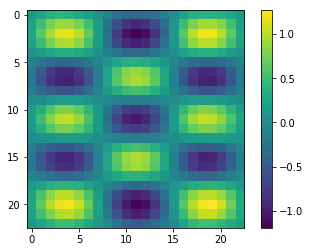

In [13]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

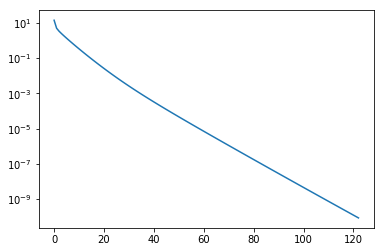

In [14]:
plt.semilogy(DMM_Res)

Radius

In [15]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.8477673959039891


Rrestriction matrix after optimization

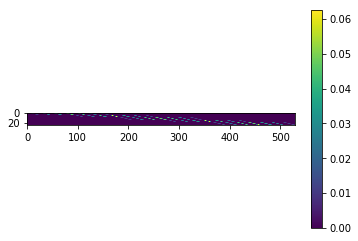

In [16]:
plt.imshow(Rnew)
plt.colorbar()

Rrestriction matrix (log(abs()) after optimization

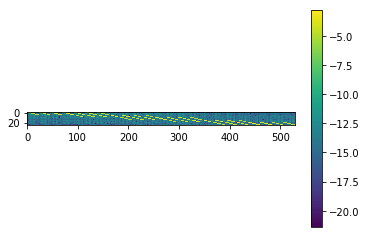

In [17]:
plt.imshow(np.log(np.abs(Rnew)))
plt.colorbar()

Basis after optimization

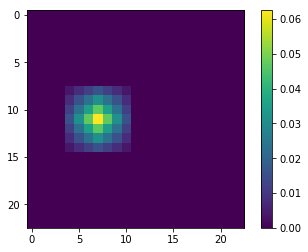

In [18]:
basis1 = Rnew[int(0.45*outputsize)][:]
basis1 = basis1.reshape([sqrtinputsize,sqrtinputsize])
plt.imshow(basis1)
plt.colorbar()

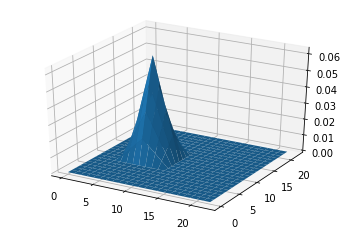

In [19]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
size=basis1.shape
Y=np.arange(0,size[0],1)     
X=np.arange(0,size[1],1)

X,Y=np.meshgrid(X,Y)    
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,basis1)
plt.show()

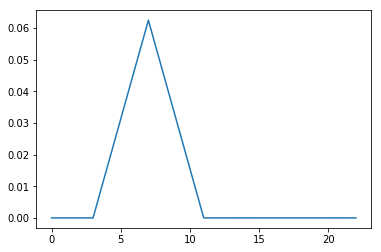

In [20]:
plt.plot(basis1[:][int(sqrtinputsize/2)])

Basis after optimization (log(abs()))

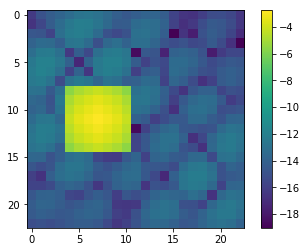

In [21]:
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()

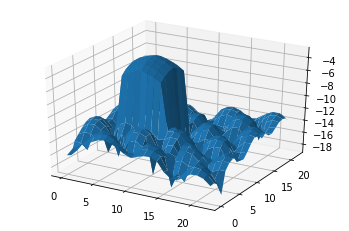

In [22]:
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(np.abs(basis1)))
plt.show()

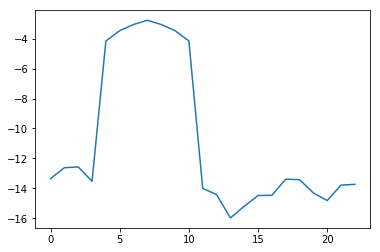

In [23]:
plt.plot(np.log(np.abs(basis1[:][int(sqrtinputsize/2)])))

FEM use basis from global DMM

Energy norm: 
6.055758368240071
L2 norm: 
0.23567416295267052
H1 norm: 
4.351111241826601
Energy norm: 
0.4810595727298395
L2 norm: 
0.47134832590534104
H1 norm: 
0.4875782718357487


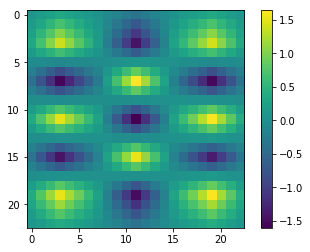

In [24]:

Anew = np.zeros([outputsize,outputsize])
[X1, Y1] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
[X2, Y2] = np.meshgrid(np.linspace(0, 1, sqrtoutputsize),np.linspace(0, 1, sqrtoutputsize))
A = a(X1,Y1)
for i in range(outputsize):
    for j in range(outputsize):
        basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
        basisj = Rnew[j][:].reshape([sqrtinputsize,sqrtinputsize])
        gxbasisi = np.gradient(basisi,axis=0)/h
        gybasisi = np.gradient(basisi,axis=1)/h
        gxbasisj = np.gradient(basisj,axis=0)/h
        gybasisj = np.gradient(basisj,axis=1)/h
        Anew[i][j]=(np.sum(A*gxbasisi*gxbasisj)+np.sum(A*gybasisi*gybasisj))*(H**2)
        
Fnew = np.zeros([outputsize,1])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    F = rightf(X1,Y1)
    Fnew[i]=np.sum(F*basisi)*(H**2)
    
UnewCoarse = np.linalg.solve(Anew,Fnew)
Unew = np.zeros([sqrtinputsize,sqrtinputsize])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    Unew = Unew + UnewCoarse[i]*basisi

plt.imshow(Unew)
plt.colorbar()

UREAL = u_real(X1,Y1).reshape(sqrtinputsize,sqrtinputsize)
deltaU = Unew - UREAL
A = a(X1,Y1)

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),A)*(h**2)))
l2norm = np.sqrt((np.sum(UREAL**2))*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))
print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))



print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum(deltaU**2))*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

In [25]:
import os
os.system("say 'The program has finished, Please check the results'")

1